<h1 align='center'><b>Фреймворк PyTorch для разработки искусственных нейронных сетей<b></h1>

<h2 align='center'>Урок 6. Нейросети в обработке текста</h2>

<h3 align='left'>Практическое задание:</h3>  

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твиттера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech







## 1. Подготовка датасета

### Описание датасета https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Цель этой задачи - обнаружить ненавистнические высказывания в твитах. Для простоты мы говорим, что твит содержит ненавистнические высказывания, если с ним связаны расистские или сексистские настроения. Итак, задача состоит в том, чтобы отличить сопротивляющиеся или сексистские твиты от других твитов.

Формально, учитывая обучающую выборку твитов и меток, где метка "1" означает, что твит является расистским / сексистским, а метка "0" означает, что твит не является расистским / сексистским, ваша цель - предсказать метки в тестовом наборе данных.

### 1. Загрузка библиотек

In [187]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [188]:
# Scientific libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# Language libraries
import string
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download("punkt")
from nltk.tokenize import word_tokenize
from string import punctuation
from string import ascii_lowercase
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re


# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('seaborn')

from tqdm import tqdm 

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2. Загрузка данных

In [189]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
!unzip -qq '/content/drive/MyDrive/Colab_Notebooks/24_PyTorch/work_6/data/archive.zip'

replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [191]:
train = pd.read_csv("train.csv")

test = pd.read_csv("test.csv")

In [192]:
train.tail(5).style.background_gradient(cmap = "summer")

,id,label,tweet
31957,31958,0,ate @user isz that youuu?ðððððððððâ¤ï¸
31958,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher
31959,31960,0,listening to sad songs on a monday morning otw to work is sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary, #wso condemns act"
31961,31962,0,thank you @user for you follow


In [193]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [194]:
print('Тренировочный датасет df_train:', train.shape)
print('Тестовый датасет df_test:', test.shape)

Тренировочный датасет df_train: (31962, 3)
Тестовый датасет df_test: (17197, 2)


## Анализ данных (Exploratory Data Analysis (EDA))<a class="anchor" id="eda"></a>

### Обзор данных<a class="anchor" id="data_overview"></a>

In [195]:
# Получим общую информацию о df_train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


**Вывод:** Пропуски в df_train отсутствуют

In [196]:
# Получим общую информацию о df_test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


**Вывод:** Пропуски в df_test отсутствуют

### Обзор целевой переменной<a class="anchor" id="target_feature_overview"></a>

**label** - метка, окраску твита.  
Имеет значения:  
0 - нормальный (позитивный) твит<br>
1 - негативный твит

In [197]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [198]:
train['label'].value_counts(1)

0    0.929854
1    0.070146
Name: label, dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


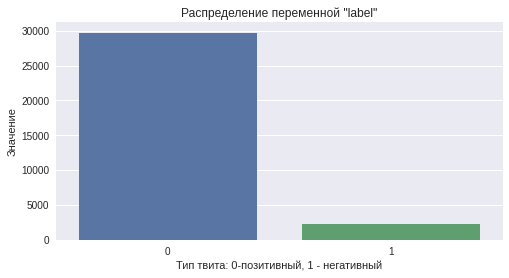

In [199]:
counts = train['label']. value_counts()

plt.figure(figsize=(8,4))
plt.title('Распределение переменной "label"')
sns.barplot(counts.index, counts.values)
plt.xlabel('Тип твита: 0-позитивный, 1 - негативный')
plt.ylabel('Значение')
plt.show()

**Вывод:** Присутствует дисбаланс классов. Класса 1 всего 7%.

In [200]:
# Проверим есть ли повторяющиеся значения
print("Всего {} повторов в  df_train".format(train.duplicated().sum()))

Всего 0 повторов в  df_train


### Определение длины текстового сообщения и % знаков препинания в тексте<a class="anchor" id="len_punct"></a>

In [201]:
# функция для вычисления длины заголовка новости без учета пробелов
train['tweet_len'] = train['tweet'].apply(lambda x: len(x) - x.count(" "))

# функция показывает процент знаков препинания в теле заголовка новости
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

train['punct%'] = train['tweet'].apply(lambda x: count_punct(x))

train.head()

,id,label,tweet,tweet_len,punct%
0,1,0,@user when a father is dysfunctional and is s...,82,3.7
1,2,0,@user @user thanks for #lyft credit i can't us...,101,7.9
2,3,0,bihday your majesty,17,0.0
3,4,0,#model i love u take with u all the time in ...,70,5.7
4,5,0,factsguide: society now #motivation,32,6.2


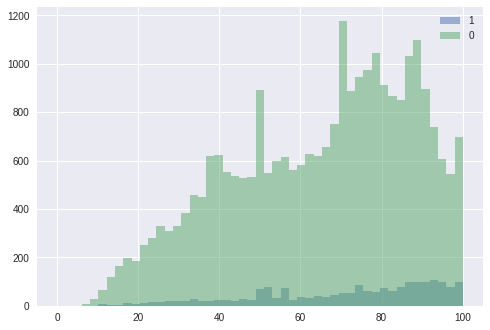

In [202]:
bins = np.linspace(0, 100, 50)

plt.hist(train[train['label'] == 1]['tweet_len'], bins, alpha=0.5, label='1')
plt.hist(train[train['label'] == 0]['tweet_len'], bins, alpha=0.5, label='0')
plt.legend(loc='upper right')
plt.show()

In [203]:
# получение списка всех слов в корпусе

def get_tweets(data):
    tweets = []
    for phrase in data:
        for word in phrase.split():
            tweets.append(word)
    return tweets

In [204]:
# Количество уникальных слов в тексте
tweets = get_tweets(train['tweet'].values)
num_words = len(set(tweets))
print(f'Количество уникальных слов в исходном тексте: {num_words}')

Количество уникальных слов в исходном тексте: 67223


## Предварительная обработка данных<a class="anchor" id="data_preprocessing"></a> 

### Разделим df_train на тестовую и проверочную части

In [205]:
df_train, df_val = train_test_split(train, test_size=0.2, random_state=42)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

df_train.tail()

,id,label,tweet,tweet_len,punct%
25564,29803,0,#waltdisneyreso should be ashamed of themselv...,107,2.8
25565,5391,0,@user invited @user over for a catch up and i...,101,5.9
25566,861,1,black professor makes assumptions about an ent...,94,2.1
25567,15796,0,#lgbtqhatetrumppay is total #liberal trash. it...,102,10.8
25568,23655,0,what makes people is relative. we have our w...,45,4.4


In [206]:
sw = set(get_stop_words("en"))
# sw

In [207]:
# Уберём из них отрицание, так как, допустим, оно несёт смысл
sw.remove('not')
sw.remove('nor')
sw.remove('no')

In [208]:
# Обозначим возможные символы
ascii_plus = ascii_lowercase + "' "
ascii_plus

"abcdefghijklmnopqrstuvwxyz' "

Попробуем развернуть сокращения с отрицанием, чтобы его оттуда вытянуть

In [209]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "can not",
"can't've": "can not have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"isn't": "is not",
"mayn't": "may not",
"mightn't": "might not",
"mightn't've": "might not have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"wasn't": "was not",
"weren't": "were not",
"won't": "will not",
"won't've": "will not have",
"wouldn't": "would not",
"wouldn't've": "would not have"
}

In [210]:
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatizer.lemmatize('feet')

'foot'

In [211]:
# Соединим отрицание с последующем информативным словом

def preprocess_text(txt, ascii_plus, contractions, lemmatizer):
    txt = str(txt)
    txt = txt.lower()
    txt = "".join(s for s in txt if s in ascii_plus)
    txt = " ".join(contractions[word] if word in contractions.keys() else word for word in txt.split())
    txt = "".join(s for s in txt if s != "'")
    txt = " ".join(lemmatizer.lemmatize(word) for word in txt.split() if word not in sw)
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("nor\s", "nor", txt)
    txt = re.sub("no\s", "no", txt)
    return txt

In [212]:
df_train['tweet'][1]

' @user raft building at salford quays as pa of the gmw fun outdoors badge #guides  @user '

In [213]:
preprocess_text(df_train['tweet'][1], ascii_plus, contractions, lemmatizer)

'user raft building salford quay pa gmw fun outdoors badge guide user'

In [214]:
df_train['tweet'].tail()

25564    #waltdisneyreso  should be ashamed of themselv...
25565     @user invited @user over for a catch up and i...
25566    black professor makes assumptions about an ent...
25567    #lgbtqhatetrumppay is total #liberal trash. it...
25568    what makes people   is relative. we have our w...
Name: tweet, dtype: object

In [216]:
df_train['tweet'] = df_train['tweet'].apply(lambda txt: preprocess_text(txt, ascii_plus, contractions, lemmatizer))
df_val['tweet'] = df_val['tweet'].apply(lambda txt: preprocess_text(txt, ascii_plus, contractions, lemmatizer))
df_train['tweet'].tail()

25564    waltdisneyreso ashamed knew alligator beach si...
25565    user invited user catch notstop talking much l...
25566    black professor make assumption entire race wh...
25567    lgbtqhatetrumppay total liberal trash amp path...
25568                      make people relative way africa
Name: tweet, dtype: object

In [217]:
df_train.head()

,id,label,tweet,tweet_len,punct%
0,12111,1,user user user ive paying attention past year ...,75,9.3
1,14082,0,user raft building salford quay pa gmw fun out...,71,4.2
2,1830,0,friday gdegblog friday selfie beard gayguy gay...,88,10.2
3,2770,0,fashion true fact,22,9.1
4,31819,0,share simple elegant businesscards designed gr...,76,9.2


Отфильтруем данные и соберём в корпус N наиболее частых токенов

In [218]:
df_train['tweet'].apply(lambda txt: nltk.tokenize.word_tokenize(txt) != txt.split()).sum()

194

Сравнивая токенизацию и split, находим, что они отличаются только в 240 примерах

In [219]:
j = 0
for i in df_train['tweet'].apply(lambda txt: nltk.tokenize.word_tokenize(txt) != txt.split()):
  if i:
    print(j)
    break
  j +=1

13


In [220]:
df_train['tweet'][j]

'udtapunjabtoflytomorrow set im gonna fly high tomorrow user user'

In [221]:
df_train['tweet'][j].split()

['udtapunjabtoflytomorrow',
 'set',
 'im',
 'gonna',
 'fly',
 'high',
 'tomorrow',
 'user',
 'user']

In [222]:
nltk.tokenize.word_tokenize(df_train['tweet'][j])

['udtapunjabtoflytomorrow',
 'set',
 'im',
 'gon',
 'na',
 'fly',
 'high',
 'tomorrow',
 'user',
 'user']

In [223]:
df_train['tweet'] = df_train['tweet'].apply(lambda txt: txt.split())
df_val['tweet'] = df_val['tweet'].apply(lambda txt: txt.split())
df_train['tweet'].tail()

25564    [waltdisneyreso, ashamed, knew, alligator, bea...
25565    [user, invited, user, catch, notstop, talking,...
25566    [black, professor, make, assumption, entire, r...
25567    [lgbtqhatetrumppay, total, liberal, trash, amp...
25568                [make, people, relative, way, africa]
Name: tweet, dtype: object

In [224]:
tokens = dict()

for txt in df_train['tweet']:
  for word in txt:
    tokens[word] = tokens.get(word, 0) + 1

sorted_tokens = sorted(tokens, key=tokens.get, reverse=True)

In [225]:
for i in range(10):
  print(sorted_tokens[i], tokens[sorted_tokens[i]])

user 13903
day 2237
love 2200
u 1328
happy 1320
amp 1290
can 1174
will 1096
just 1044
life 1008


In [226]:
len(sorted_tokens)

33447

Возьмём из токенов первые max_words-1 элементов, так как у нас будет ещё один элемент 0, обозначающий отсутсвие слова

In [227]:
max_words = 10000
max_words

10000

In [228]:
vocabulary = {w: i for i, w in enumerate(sorted_tokens[:max_words-1], 1)}
for i in list(vocabulary.keys())[:10]:
  print(i, vocabulary[i])

user 1
day 2
love 3
u 4
happy 5
amp 6
can 7
will 8
just 9
life 10


In [229]:
sorted_tokens[max_words-1], tokens[sorted_tokens[max_words-1]]

('bfs', 2)

Последний взятый токен встречался всего 2 раза, значит можно предположить, что наш словарь имеет почти все информативные слова

### Определим рабочую длину строки

In [230]:
df_train['tweet'].apply(lambda txt: len(txt)).max()

24

In [231]:
df_train['tweet'].apply(lambda txt: len(txt)).mean()

8.402948883413508

In [232]:
max_len = 10
max_len

10

Такой максимальной длиной мы довольно хорошо описываем наши примеры, так как она больше средней, при этом не перегружаем модель, как если бы мы брали максимальную длину примеров

Приведём данные к числовым векторам одинаковой длины

In [233]:
def text_to_sequence(txt, vocabulary, maxlen):
  response = []
  for w in txt:
    if w in vocabulary.keys():
      response.append(vocabulary[w])
    if len(response) == maxlen:
      break
  response += [0]*(maxlen-len(response))
  return response

In [234]:
df_train['tweet'] = df_train['tweet'].apply(lambda txt: text_to_sequence(txt, vocabulary, max_len))
df_val['tweet'] = df_val['tweet'].apply(lambda txt: text_to_sequence(txt, vocabulary, max_len))
df_train['tweet'].tail()

25564          [2310, 1045, 1323, 178, 671, 1, 0, 0, 0, 0]
25565      [1, 3197, 1, 1509, 2416, 677, 80, 3, 201, 1973]
25566    [120, 24, 1069, 376, 2446, 2157, 1069, 376, 83...
25567           [1434, 343, 2251, 6, 675, 391, 0, 0, 0, 0]
25568              [24, 21, 3598, 42, 1702, 0, 0, 0, 0, 0]
Name: tweet, dtype: object

### Построение модели

In [236]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, max_len, vocab_size, embedding_dim, out_channel, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [237]:
# model = Net(max_len, max_words, 64, 0, 64, 1, 0.2)
model = Net(max_len, max_words, 64, 64, 1)

In [238]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(10000, 64)
  (conv_1): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=64, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=1, bias=True)
)
Parameters: 662721


In [239]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target):
        data_numpy = np.array([[j for j in i] for i in data])
        self.data = torch.from_numpy(data_numpy).long()
        self.target = torch.from_numpy(target).long()
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
            
        return x, y
    
    def __len__(self):
        return len(self.target)

In [240]:
batch_size = 1024

In [241]:
train_dataset = DataWrapper(df_train['tweet'].values, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(df_val['tweet'].values, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

### Обучение

In [242]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [243]:
def BCE_weigh(weight=1):

  def loss(input, target):
    input = torch.clamp(input,min=1e-7,max=1-1e-7)
    target = torch.clamp(target,min=1e-7,max=1-1e-7)
    bce = - weight * target * torch.log(input) - (1 - target) * torch.log(1 - input)
    return torch.mean(bce)

  return loss

In [244]:
disbalance = df_train['label'].value_counts()[0] / df_train['label'].value_counts()[1]
disbalance

13.316349384098544

In [245]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = nn.BCELoss()
criterion = BCE_weigh(weight=disbalance)

In [246]:
model = model.to(device)
model.train()
epochs = 10
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/10]. Step [25/25]. Loss: 0.977. Acc: 0.476. Test loss: 0.766. Test acc: 0.850
Epoch [2/10]. Step [25/25]. Loss: 0.630. Acc: 0.875. Test loss: 0.008. Test acc: 0.885
Epoch [3/10]. Step [25/25]. Loss: 0.371. Acc: 0.939. Test loss: 0.024. Test acc: 0.899
Epoch [4/10]. Step [25/25]. Loss: 0.135. Acc: 0.969. Test loss: 31.552. Test acc: 0.941
Epoch [5/10]. Step [25/25]. Loss: 0.054. Acc: 0.984. Test loss: 0.000. Test acc: 0.941
Epoch [6/10]. Step [25/25]. Loss: 0.033. Acc: 0.991. Test loss: 0.000. Test acc: 0.949
Epoch [7/10]. Step [25/25]. Loss: 0.040. Acc: 0.995. Test loss: 0.000. Test acc: 0.946
Epoch [8/10]. Step [25/25]. Loss: 0.043. Acc: 0.996. Test loss: 0.000. Test acc: 0.945
Epoch [9/10]. Step [25/25]. Loss: 0.007. Acc: 0.998. Test loss: 0.000. Test acc: 0.952
Epoch [10/10]. Step [25/25]. Loss: 0.012. Acc: 0.997. Test loss: 0.000. Test acc: 0.947
Training is finished!


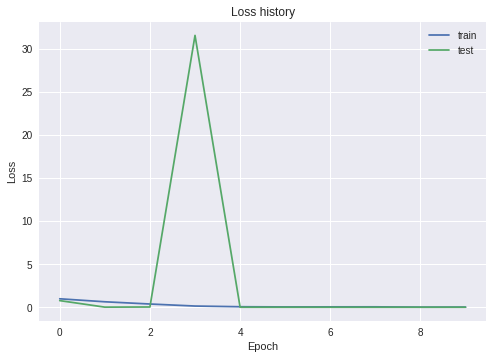

In [248]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();